Task 1

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

# first preprocessing data

df = pd.read_csv("lego_sets.csv")
print("Dataset shape:", df.shape)
df.head()

# binary classification target variable - yes true 1 - no false 0
df['popular'] = (df['US_retailPrice'] > 100).astype(int)

# select features to use to predict popularity
features = ['minifigs','agerange_min','year','pieces']
X = df[features].copy() # feature matrix - inputs
y = df['popular'] # target vector - output

for col in features:
    X[col] = pd.to_numeric(X[col], errors='coerce') # convert val to num non-numeric become nan
    X[col] = X[col].fillna(X[col].median()) # replace missing val with median of col

# splitting data into training and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, # 20% into test 80% into training
    random_state=42,
    stratify=y # sets proportion of popular not popular sets in test and train the same
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Class balance:\n", y_train.value_counts(normalize=True))

Dataset shape: (18457, 14)
Train shape: (14765, 4)
Test shape: (3692, 4)
Class balance:
 popular
0    0.97765
1    0.02235
Name: proportion, dtype: float64


The preprocessing for the decision tree classifier is different than the logistic regression classification from homework 1, because no scaling is required. Only the missing values need to be handled and potential encoding of the categories. For logistic regression, preprocessing requires numeric scaling, one-hot encoding of categories, and potential column transformation for model performance. The decision tree cares about the order of the values, but the logistic regression cares about the magnitude of values. The models have different mathematical assumptions and sensitivities. Again, the binary classification target variable is created with 1 being popular and 0 being not popular. The features are then selected to use for predicting popularity, and the inputs and outputs of the feature matrix and target vector are created. The data is then preprocessed to convert values to numbers and non-numeric values to NaN. It also replaces missing values NaN with the median of the column. This helps to ensure all columns are numeric. The dataset is then split into training and testing, 20% in the test set and 80% in training. Stratify ensures the proportion of popular vs non-popular sets are the same in both sets.

In [20]:
# decision tree classifier
# splits data based on feature thresholds to predict target
tree1 = DecisionTreeClassifier(max_depth=2, random_state=42)
tree2 = DecisionTreeClassifier(max_depth=4, random_state=42)
tree3 = DecisionTreeClassifier(max_depth=None, random_state=42) # no limit of depth

# training model using X_train y_train
# learning splits to seperate popular vs not popular
tree1.fit(X_train, y_train)
tree2.fit(X_train, y_train)
tree3.fit(X_train, y_train)

for model, name in zip([tree1, tree2, tree3],
                       ["Depth 2", "Depth 4", "Full Depth"]):
    acc = model.score(X_test, y_test) # num correct pred/total pred
    print(f"{name} Accuracy: {acc:.4f}")

Depth 2 Accuracy: 0.9862
Depth 4 Accuracy: 0.9867
Full Depth Accuracy: 0.9819


The decision tree classifier is a model that splits data based on feature thresholds to predict the target. max_depth is the parameter to set how deep the tree can grow. The value None means that there is no limit of depth, and the tree can grow until all leaves are there; this can cause a risk of overfitting. The model is then trained with the training data, and the tree learns the splits to separate the popular vs non-popular sets. Accuracy is then evaluated by the number of correct predictions over the total number of predictions. The output shows how tree depth affects performance. Depth of 2 shows a very shallow tree, only a few splits, so a simpler model. This can underfit but the accuracy is high. A depth of 4 is slightly deeper with more splits and captures more patterns with a little higher accuracy. Then the None depth is letting the tree fully grow, and it is seen that the accuracy drops slightly, showing overfitting error.

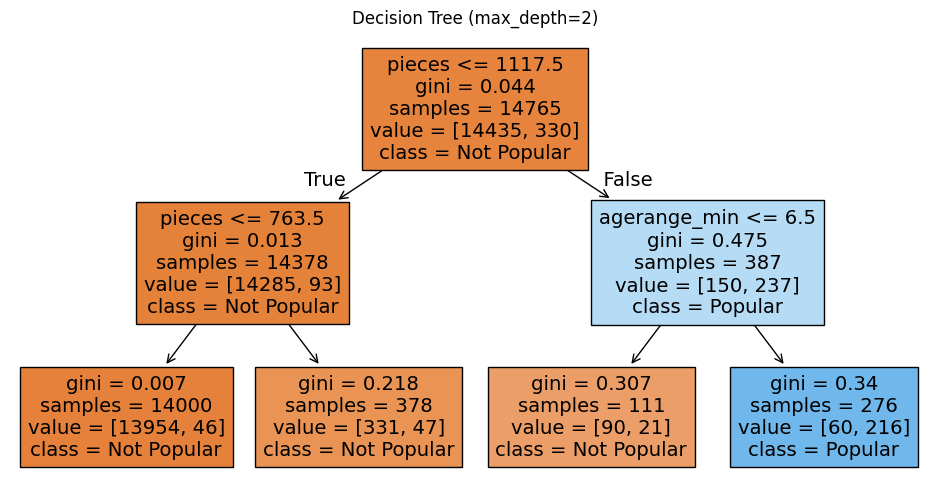

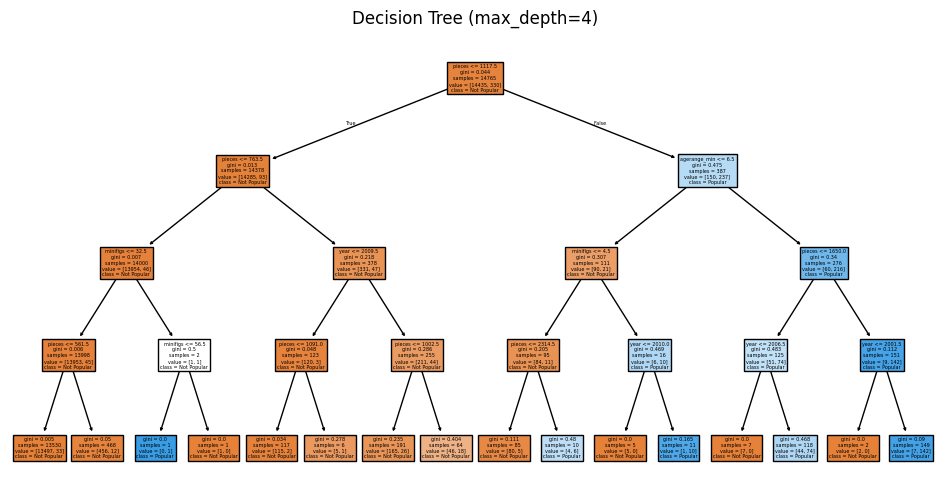

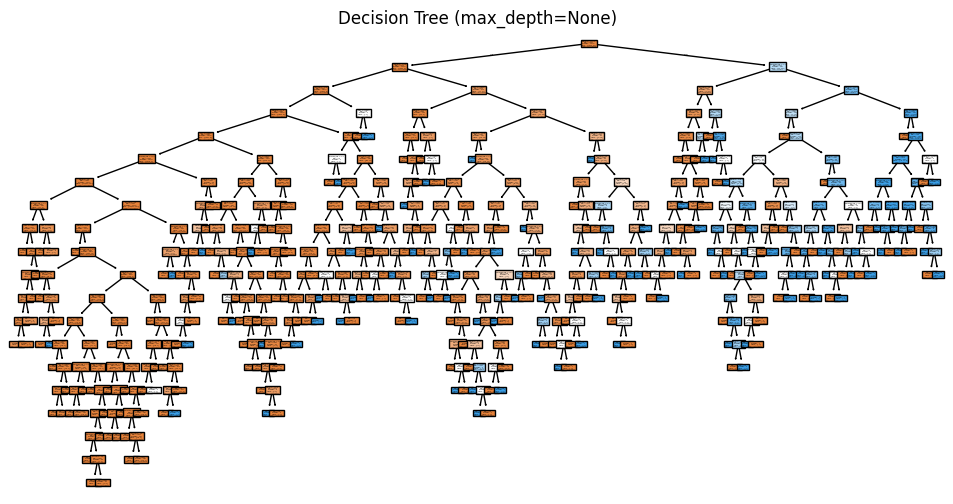

In [21]:
# visualize decision tree structure
for model, depth in zip([tree1, tree2, tree3], [2,4,None]):
    plt.figure(figsize=(12,6))
    plot_tree(model,
              feature_names=X.columns,
              class_names=["Not Popular","Popular"],
              filled=True)
    plt.title(f"Decision Tree (max_depth={depth})")
    plt.show()

How depth and complexity change a tree

As the tree depth increases, the number of decision rules also increases. The model becomes more complex, and the decision boundary becomes more detailed. The interpretability of the tree decreases. For example, if the depth of the tree is 2 levels, it is a very simple tree with few rules and may underfit. With 4 levels, there are more splits that capture interactions, making it more balanced. If there are too many levels, there are too many branches, making it very detailed and increasing the risk of overfitting. The numerical values are explained above, and this shows the visualization of the actual depth.

From the actual diagrams of the trees, there are several variables in each node of the tree. The top-most box in each depth is the root node. pieces <= 1117.5 shows the split condition, and this feature is used to split the data at this node. If pieces <= 1117.5, then it goes into the left branch, and if pieces > 1117.5 it goes to the right branch. gini = 0.044 is the gini impurity, and it measures how mixed the classes are at the current node. samples = 14765 shows the number of samples of total data points at the current node, the training data. value = [14435, 330] shows the class distribution, [not popular, popular]. class = not popular shows the predicted class at the current node. The majority class of the node, so if a new sample lands there, the tree stops and it would predict not popular. This goes on for each tree depending on how many depths there are.

Sensitivity analysis research

Sensitivity analysis measures how changes in an input variable affect the model output. It identifies which features most influence predictions. More specifically, it shows how an independent variable affects a dependent variable under a given set of assumptions. It is used to predict how changes in various variables are likely to affect an outcome. To perform it, an input is selected and modified by a specific amount to see how much it impacts the output. Inputs are often varied by a fixed percentage to assess sensitivity.

There are multiple methods to perform sensitivity analysis. OAT (one-at-a-time) analysis alters one input variable while maintaining the other ones constant. However, this method can miss interactive effects between variables. Differential analysis calculates the rate of change in the output based on minute changes in the input, which allows ranking of sensitivity. Scenario analysis adjusts multiple inputs simultaneously to model different situations, allowing many possible outcomes. Monte Carlo simulation uses repeated random sampling of input variables to generate a probability distribution of potential outcomes, which is useful for models involving uncertainty. Lastly, tornado diagrams illustrate the sensitivity rankings of the inputs graphically, where a wider bar indicates a larger impact.

Citations: https://www.investopedia.com/terms/s/sensitivityanalysis.asp
https://www.capitalcitytraining.com/knowledge/sensitivity-analysis/#Section_04

In [22]:
print("Feature importances:")
for name, importance in zip(X.columns, tree2.feature_importances_):
    print(name, importance)

Feature importances:
minifigs 0.023004585559778627
agerange_min 0.14112327911498768
year 0.045832354739696
pieces 0.7900397805855377


The feature importance shows how much a feature contributes to reducing impurity (Gini) across all splits in the tree. A higher number means the feature is more important in making decisions in the tree. Analyzing the results shows that pieces is the most important feature with 0.79, and most splits and decisions in the tree are based on pieces. This helps show larger sets are more likely to be popular. agerange_min is the second most important with 0.14, so it influences the popularity somewhat but not as much. year and minifigs have smaller impact with 0.046 and 0.023, so they only slightly influence popularity in the model. This is helpful to look at before sensitivity analysis because it’s a quick estimate of which features the model relies on most for predictions. It helps to validate the understanding of the model with sensitivity analysis as a simple cross-check.

In [23]:
# sensitivity analysis

def sensitivity_analysis(model, X_data, feature_name, change=0.1):
    X_mod = X_data.copy() # copying so og is unchanged
    X_mod[feature_name] *= (1 + change) # 10% increase of feature

    # predicts with og and modified data with single changed feature
    preds_orig = model.predict(X_data)
    preds_mod = model.predict(X_mod)

    # compares predictions
    return np.mean(preds_orig != preds_mod)

# apply function to all features to see how sensitive tree3 (full depth) is to each feature
sens_minifigs = sensitivity_analysis(tree3, X_test.copy(), 'minifigs')
sens_agerange = sensitivity_analysis(tree3, X_test.copy(), 'agerange_min')
sens_year = sensitivity_analysis(tree3, X_test.copy(), 'year')
sens_pieces = sensitivity_analysis(tree3, X_test.copy(), 'pieces')

# shows proportions of predictions changed after modification
print("Sensitivity (minifigs):", sens_minifigs)
print("Sensitivity (agerange_min):", sens_agerange)
print("Sensitivity (year):", sens_year)
print("Sensitivity (pieces):", sens_pieces)

Sensitivity (minifigs): 0.0008125677139761647
Sensitivity (agerange_min): 0.0032502708559046588
Sensitivity (year): 0.010834236186348862
Sensitivity (pieces): 0.010834236186348862


This first sensitivity analysis function performs OAT sensitivity analysis on the decision tree. First, a modified version of the original dataset is created so the original data is unchanged when testing sensitivity. To alter the feature, it multiplies the chosen feature by 1 + change, which equates to a default 10% increase. This shows the OAT method, changing one input while keeping the others fixed. To compare, it predicts using the original test data and the test data after changing the single feature. It compares the predictions before and after the change and returns the proportion of the predictions that changed. The function is applied to all features to see how sensitive the full tree depth tree is to each feature individually. A higher value means the model is more sensitive to the feature, and lower means it has little effect on the predictions.

In [24]:
# modified sensitivity analysis

def sensitivity_analysis_with_shift(model, X_data, feature_name, shift):
    X_mod = X_data.copy()
    X_mod[feature_name] += shift # absolute shift
    preds_orig = model.predict(X_data)
    preds_mod = model.predict(X_mod)
    return np.mean(preds_orig != preds_mod) # proportions of pred changed

# adding shift to test how much adding to feature to test sensitivity
sens_minifigs = sensitivity_analysis_with_shift(tree3, X_test.copy(), 'minifigs', shift=5) # adding 5 minifigs to each test sample
sens_agerange = sensitivity_analysis_with_shift(tree3, X_test.copy(), 'agerange_min', shift=2) # increase min age by 2 years
sens_year = sensitivity_analysis_with_shift(tree3, X_test.copy(), 'year', shift=3) # increase date by 3 years
sens_pieces = sensitivity_analysis_with_shift(tree3, X_test.copy(), 'pieces', shift=10) # adding 10 pieces

print("Sensitivity (minifigs):", sens_minifigs)
print("Sensitivity (agerange_min):", sens_agerange)
print("Sensitivity (year):", sens_year)
print("Sensitivity (pieces):", sens_pieces)

Sensitivity (minifigs): 0.021397616468039005
Sensitivity (agerange_min): 0.008938244853737811
Sensitivity (year): 0.006229685807150596
Sensitivity (pieces): 0.004875406283856988


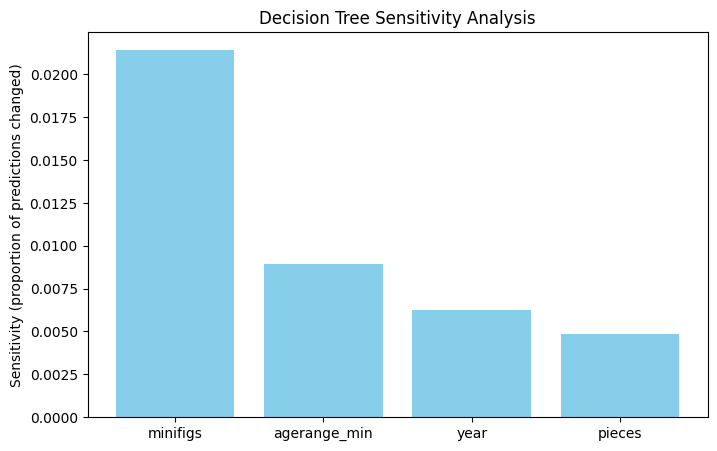

In [25]:
# sensitivity values for features
features = ['minifigs','agerange_min','year','pieces']
sens_values = [sens_minifigs, sens_agerange, sens_year, sens_pieces]

# plotting values bar plot to comapre sensitivity
plt.figure(figsize=(8,5))
plt.bar(features, sens_values, color='skyblue')
plt.ylabel("Sensitivity (proportion of predictions changed)")
plt.title("Decision Tree Sensitivity Analysis")
plt.show()

Sensitivity analysis interpretation

This method is a performance of OAT (one-at-a-time) sensitivity analysis because the decision tree model was altering one feature at a time while keeping the other ones consistent. For each feature, an absolute shift was applied, and the proportion of the test predictions that changed as a result was measured. This allows quantifying which inputs directly influence the model’s predictions. Looking at the results, higher sensitivity means the model’s decisions depend more on the feature being measured, while lower sensitivity means the feature has a weaker effect.

minifigs and agerange_min had the strongest impacts on the predictions, with sensitivities of about 2.14% and 0.89%, showing that changes in these features are more likely to affect the prediction of a LEGO set’s popularity. year had a sensitivity of 0.62%, and pieces had 0.49%, meaning they still influence the model but to a smaller extent compared to minifigs and agerange_min.

Adding the shift in the second method from the original sensitivity analysis allowed the model to better test how sensitive it is to meaningful feature changes. Shift is how much is added to the feature to test sensitivity. For each feature, it is increased by a specific number to test how much the predictions change. For example, adding 5 minifigs increased the sensitivity from 0.08% to 2.14%, showing that minifigs have a noticeable impact on the tree’s decisions. It goes on to increase the minimum age range by 2 years increasing from 0.3% to 0.8% showing age also has impact on the predictions. The year date is increased by 3 years with the percentage going from 1.08% to 0.62% showing that the year range can also slightly influence popularity. Adding 10 pieces to each test sample changed the percentage from 1.08% to 0.48% which also signifies pieces is a big influencer on predictions. Since more predictions changed, the measured sensitivity increased. This demonstrates OAT because all features are kept the same while only one feature is changed at a time, showing the independent influence of each feature on the model’s decisions. The first method scaled features by 10%, which often did not change the tree’s decisions because it relied on threshold splits. Adding a larger absolute shift in the second method resulted in higher measured sensitivity. Comparing the two methods sensitivity outputs shows how different inputs have different affect on each of the features. This explains that there can be different sensitivites based on how much a feature is changed.

Task 2

In [26]:
# one algorithm from each bagging and boosting ensemble methods

from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

# bagging: generic bagging
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=4),
    n_estimators=100, # num trees in ensemble
    random_state=42
)

# boosting: adaboost
boosting_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100, # num sequential trees
    random_state=42
)

Bagging, Bootstrap Aggregating, trains independent models on random samples of the training data. It aggregates the predictions using classification or regression, vote or averaging. It mimics random forest without the feature subsampling. BaggingClassifier is the choice of the one algorithm from the Bagging ensemble method; it is a generic bagging algorithm. In terms of the LEGO dataset, it trains independent decision trees on random subsets and predicts whether a set is popular by majority vote, which reduces variance.

Boosting trains the model sequentially, where each model focuses on examples of what the previous models got wrong. It again combines models with classification or regression, but this time the weights of them. AdaBoost is a common boosting algorithm that improves weak learners by focusing on mistakes. Here, in terms of the LEGO dataset, it trains sequential trees which focus on LEGO sets misclassified by previous trees and then combines their weighted predictions to improve accuracy and reduce bias.

Citations: https://www.geeksforgeeks.org/machine-learning/what-is-bagging-classifier/

https://www.geeksforgeeks.org/machine-learning/adaboost-in-machine-learning/

Stratified k-fold cross-validation research

Stratified k-fold cross-validation is used to evaluate a model in classification problems where the labels are not evenly distributed, the data is imbalanced. Stratified ensures class imbalance and does not distort evaluation. A fold is one subset of the dataset. k-folds mean it splits the dataset into k equal parts, folds. Each fold takes a turn as the testing set, and the remaining are the training set, so each data point is tested exactly once. The different folds allow seeing if the model’s performance is sensitive to a certain fold number.

Citation: https://www.geeksforgeeks.org/machine-learning/stratified-k-fold-cross-validation/

In [27]:
# stratified k-fold cross-validation with three different folds

from sklearn.model_selection import StratifiedKFold, cross_validate

scoring = ['accuracy', 'precision', 'f1']
dif_folds = [5, 10, 15]

for folds in dif_folds:
    print(f"\n{folds}-fold stratified cross-validation")

    # splits data into folds preserving class proportions
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
                                          # shuffles data befores splitting

    # trains and evaluates model fold by fold
    # returns dict with test scores for each fold
    bag_results = cross_validate(bagging_model, X, y, cv=skf, scoring=scoring)
    boost_results = cross_validate(boosting_model, X, y, cv=skf, scoring=scoring)

    # evaluate models with three evaluation metrics
    print("\nBagging:")
    print("Accuracy:", bag_results['test_accuracy'].mean())
    print("Precision:", bag_results['test_precision'].mean())
    print("F1 Score:", bag_results['test_f1'].mean())

    print("\nBoosting (AdaBoost):")
    print("Accuracy:", boost_results['test_accuracy'].mean())
    print("Precision:", boost_results['test_precision'].mean())
    print("F1 Score:", boost_results['test_f1'].mean())


5-fold stratified cross-validation

Bagging:
Accuracy: 0.9884596892150478
Precision: 0.8208657931620851
F1 Score: 0.7062473078318267

Boosting (AdaBoost):
Accuracy: 0.9878095176313911
Precision: 0.7819211662423108
F1 Score: 0.6989915735901382

10-fold stratified cross-validation

Bagging:
Accuracy: 0.9883516106016966
Precision: 0.8119067545260391
F1 Score: 0.7061801329978306

Boosting (AdaBoost):
Accuracy: 0.9878096051816423
Precision: 0.7760606522321293
F1 Score: 0.7023583303802428

15-fold stratified cross-validation

Bagging:
Accuracy: 0.9881889930190936
Precision: 0.8051467306299673
F1 Score: 0.7016964076446507

Boosting (AdaBoost):
Accuracy: 0.9879180783684359
Precision: 0.7828582725672847
F1 Score: 0.7036162506495333


In the above code, the metrics of accuracy, precision, and F1 are used to evaluate the model on each of the folds. The different number of folds is how many to try for cross-validation. This allows seeing how the evaluation changes with more or fewer folds. StratifiedKFold splits the data into folds while preserving the class proportions, which is important for imbalanced datasets. It shuffles the data before splitting and makes the splits reproducible with the random state. cross_validate trains and evaluates the model fold by fold and returns a dictionary with the test scores for each fold. Taking the mean across folds allows getting a stable estimate of model performance. This allows comparison of Bagging vs Boosting with different cross-validation splits on the dataset.

Behavior of each algorithm

For accuracy, Bagging has slightly higher accuracy than Boosting throughout, being compared 0.988 vs 0.987. There are very small differences, as it seems both algorithms are performing really well. However, seeing from the previous homework, looking at just the accuracy could overstate performance because the classes could be imbalanced. The precision is higher in all of the Bagging folds, which means that when Bagging predicts a set as popular, it is more correct than when Boosting does. Boosting is a little lower, which indicates more false positives, predicting the set is popular when it is not. Bagging and Boosting are very close for the F1 score, around 0.7. Boosting goes up slightly with more folds, which suggests Boosting might have a slightly better recall even if precision is lower.

Increasing the number of folds slightly decreased the precision for Bagging from 0.821 to 0.805. It slightly increased in F1 for Boosting, with it being 0.699 to 0.704. Larger folds lead to more training data per fold, so models are more stable. The differences, however, are minor because the dataset is on the larger side.

The performance ranking does change depending on the metric used, by looking at the outputs of each metric. The accuracy is better for Bagging than Boosting, precision better for Bagging than Boosting, and F1 score is very similar but Boosting is better than Bagging in the 15-fold. Bagging favors overall correctness and fewer false positives. Boosting can slightly improve F1 by getting more true positives with higher recall even if precision drops. This happens because the Bagging Classifier algorithm for Bagging reduces variance and improves model stability by combining multiple models. The AdaBoost algorithm for Boosting focuses on misclassified samples, which can improve recall, slightly reduce precision, and could lead to improvement in F1 score. The different metrics capture different aspects of performance, so the ranking is metric-dependent.

Task 3


Decision Tree Confusion Matrix:
 [[3582   28]
 [  39   43]]


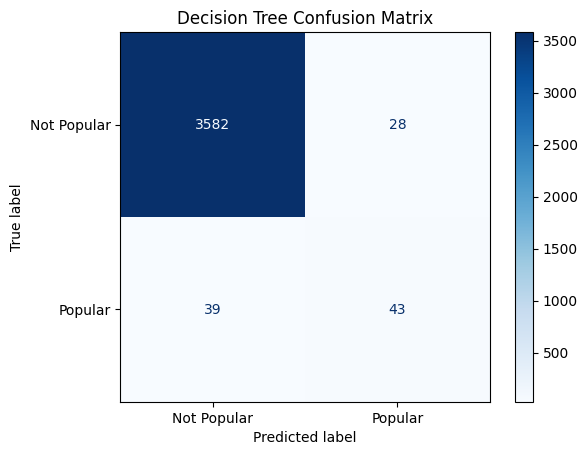


Bagging Confusion Matrix:
 [[3597   13]
 [  36   46]]


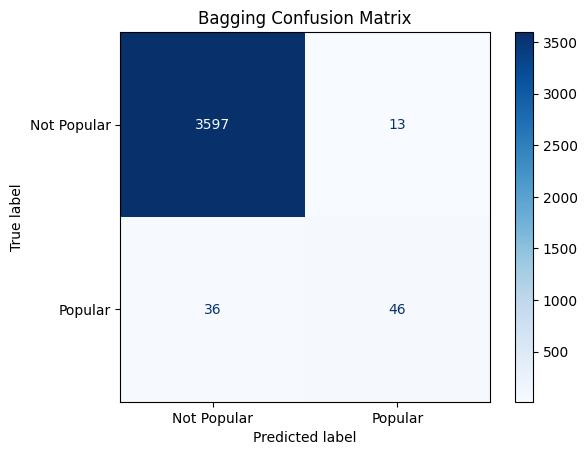


Boosting Confusion Matrix:
 [[3596   14]
 [  33   49]]


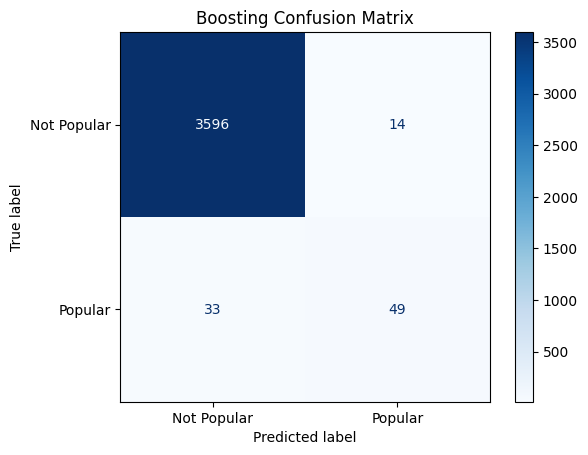

In [28]:
# confusion matrix for one selected test fold

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# using test set from previous splits
models = {
    "Decision Tree": tree3, # full depth tree
    "Bagging": bagging_model,
    "Boosting": boosting_model
}

for name, model in models.items():
    # fit bagging and boosting on full training data
    if name != "Decision Tree":
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test) # predicted class for test set
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name} Confusion Matrix:\n", cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Popular","Popular"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

A confusion matrix shows where the model makes mistakes, if it misclassifies popular sets as not popular or the other way around. It helps compare decision tree, Bagging, and Boosting performance on the same test set. True negative has predicted 0 and actual 0, false positive has predicted 1 and actual 0, false negative has predicted 0 and actual 1, and true positive has predicted 1 and actual 1. Accuracy can be misleading if classes are imbalanced, so confusion matrix helps to see the predictions.

In [29]:
# statistical test

from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel

# 10-fold cross-validation for the test
cv = 10 # splits data into 10 parts evaluates model on each fold

# decision tree accuracy across folds
# returns vector of 10 accuracy vals
dt_scores = cross_val_score(tree3, X, y, cv=cv, scoring='accuracy')
bagging_scores = cross_val_score(bagging_model, X, y, cv=cv, scoring='accuracy')
boosting_scores = cross_val_score(boosting_model, X, y, cv=cv, scoring='accuracy')

# paired t-tests
t_stat_dt_bag, p_val_dt_bag = ttest_rel(dt_scores, bagging_scores)
t_stat_dt_boost, p_val_dt_boost = ttest_rel(dt_scores, boosting_scores)
t_stat_bag_boost, p_val_bag_boost = ttest_rel(bagging_scores, boosting_scores)

print("Paired t-test:")
print(f"Decision Tree vs Bagging: t={t_stat_dt_bag:.3f}, p={p_val_dt_bag:.3f}")
print(f"Decision Tree vs Boosting: t={t_stat_dt_boost:.3f}, p={p_val_dt_boost:.3f}")
print(f"Bagging vs Boosting: t={t_stat_bag_boost:.3f}, p={p_val_bag_boost:.3f}")

Paired t-test:
Decision Tree vs Bagging: t=-2.491, p=0.034
Decision Tree vs Boosting: t=-3.035, p=0.014
Bagging vs Boosting: t=-0.901, p=0.391


In the statistical tests, 10-fold cross-validation is used for the test, splitting the data into 10 parts and evaluating the model on each fold. It computes the model scores across multiple cross-validation folds. It runs 10-fold CV on each model and returns a vector of 10 accuracy values, one for each of the folds. This allows for comparison of the models on the same fold. In the paired t-tests, ttest_rel tests if the mean difference between two paired samples is different from 0. It is paired because each fold corresponds between models, so the scores are related. It returns the size difference and the probability of observing the difference. If the p-value < 0.05, the difference in accuracy is statistically significant, and if the p-value > 0.05, the difference is not statistically significant. This helps to see if Bagging is better than a single decision tree or if the difference is random. Using a paired test accounts for the fact that the same data folds are used for all models, making the test more reliable than an unpaired test.

Analysis of results and discussion on the trade-off

Looking at the confusion matrix for the Decision Tree, there are 3582 true negatives and 43 true positives. For the false positives, there are 28, and for false negatives, 39. The tree correctly identifies most of the not-popular sets but struggles with the popular sets, as there are many false negatives. For the BaggingClassifier, there are 3597 TN and 13 FP, so there are fewer false positives than the Decision Tree. There are 36 FN and 46 TP, so there is slightly better recall for popular sets. Bagging reduces variance by averaging multiple trees on bootstrap samples, which leads to more stable predictions and slightly better overall accuracy and precision. Boosting has 3596 TN and 14 FP, so it is comparable to Bagging. It has better recall for popular sets than both the Decision Tree and Bagging, with 33 FN and 49 TP. AdaBoost focuses on correcting misclassified samples, which improves recall at the cost of slightly more false positives compared to Bagging.

Looking at the paired t-test results, the Decision Tree vs. Bagging has a significant difference with p < 0.05. Bagging improves accuracy over the single tree. Decision Tree vs. Boosting also has a significant difference, so Boosting also improves over the single tree. Bagging vs. Boosting is not significant with p > 0.05, so both ensemble methods perform similarly in accuracy.

Regarding the bias-variance trade-off, the Decision Tree is prone to overfitting on training data, so it has less stable predictions. It has low bias and high variance, resulting in moderate recall. The BaggingClassifier has low bias and lower variance than a single tree. Averaging multiple trees reduces variance, making predictions more stable and leading to fewer misclassifications. AdaBoost can reduce bias and has moderate variance. It focuses on misclassified samples by improving predictions for underrepresented examples. It has slightly higher variance than Bagging but better recall.

Bagging and Boosting improve over a single Decision Tree. Bagging stabilizes predictions by averaging and improving precision and accuracy. Boosting focuses on misclassified samples, improving recall and F1 score. The confusion matrices show that Bagging and Boosting better handle the minority class (popular sets) than a single tree. The choice between Bagging and Boosting depends on whether the goal of the model is stability (Bagging) or better recall for underrepresented classes (Boosting).